In [1]:
import PWS
using PWS: Trajectory, SMCEstimate, DirectMCEstimate, marginal_configuration, MarginalEnsemble, ConditionalEnsemble, gene_expression_system, generate_configuration, logpdf, cooperative_chemotaxis_system, reaction_network
using StaticArrays
import Catalyst
using DiffEqBase
using DiffEqJump
import ModelingToolkit
using CairoMakie

In [425]:
params = (;
    E₀ = 3.0,
    lmax = 3,
    mmax = 3*3,
    Kₐ = 500, # unit: μM (from MeASP data)
    Kᵢ = 25, # unit: μM
    δf = -1.5,
    k_B = 0.1, # demethylation of active receptor
    k_R = 0.1, # methylation of inactive receptor
    n_clusters = 800,
    k⁺ =  1 / (0.01 * 500), # ligand binding rate to active or inactive receptor
    n_chey = 10_000,
    mean_l = 50,
    tau_l = 1.0,
    phosphorylate = 1/6 * 10/(1+1/6) / 400,
    dephosphorylate = 10/(1+1/6)
)

# for convenience
E0 = params.E₀
δg = log(params.Kₐ/params.Kᵢ)
δf = params.δf
Kₐ = params.Kₐ
Kᵢ = params.Kᵢ
n_clusters = params.n_clusters
lmax = params.lmax
mmax = params.mmax

params


(E₀ = 3.0, lmax = 3, mmax = 9, Kₐ = 500, Kᵢ = 25, δf = -1.5, k_B = 0.1, k_R = 0.1, n_clusters = 800, k⁺ = 0.2, n_chey = 10000, mean_l = 50, tau_l = 1.0, phosphorylate = 0.003571428571428571, dephosphorylate = 8.571428571428571)

In [417]:
# plot recipe for trajectories
function Makie.convert_arguments(P::PointBased, x::PWS.Trajectory)
    t_vals = eltype(x.t)[]
    u_vals = eltype(x.u)[]
    i = 1
    while i < length(x.t)
        push!(t_vals, x.t[i])
        push!(u_vals, x.u[i+1])
        i += 1
        push!(t_vals, x.t[i])
        push!(u_vals, x.u[i])
    end
    
    Makie.convert_arguments(P, t_vals, vcat(u_vals...))
end

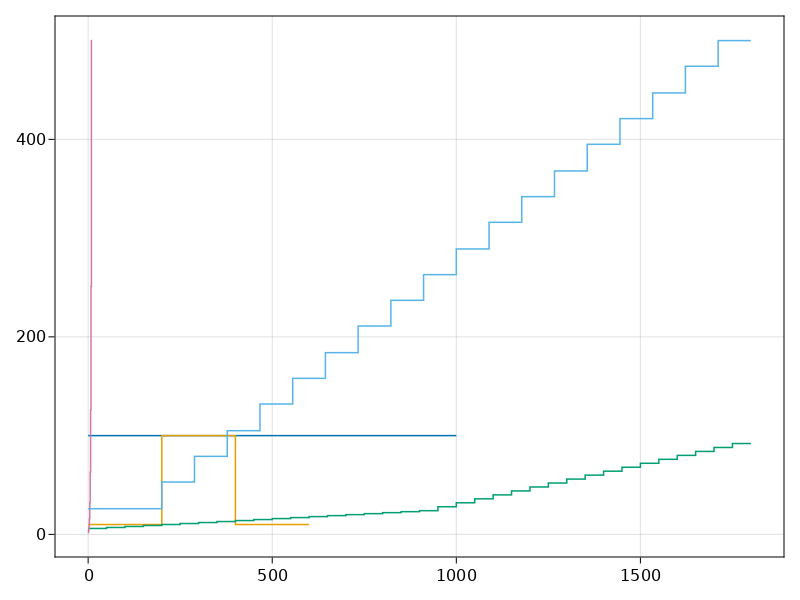

In [453]:
system = cooperative_chemotaxis_system(; dtimes=0.0:1:100, params...)
const_s = Trajectory([[100], [100]], [0.0, 1000])
step_s = Trajectory([[10], [10], [100], [10]], [0.0, 200, 400, 600])
gradient_s = Trajectory(vcat([[x] for x in 5:1:23], [[x] for x in 24:4:92]), collect(0.0:50.0:1800.0))
ramp_s = Trajectory([[round(Int, x)] for x in exp.(range(log(1), log(500), length=10))], collect(range(0, 10, length=10)))
monotonic_s = Trajectory([[round(Int, x)] for x in range(0, 500, length=20)], vcat(0.0, collect(range(200.0, 1800, length=19))))
lines(const_s)
lines!(step_s)
lines!(gradient_s)
lines!(ramp_s)
lines!(monotonic_s)
current_figure()

In [428]:
system.px

2-element Vector{Float64}:
 8.571428571428571
 0.003571428571428571

In [449]:
function solve_system(system, s_traj; saveat=0.1)
    rx = merge(system.rn, system.xn)

    u0 = copy(system.u0)
    u0[1] = s_traj.u[1][1]
    dprob = DiscreteProblem(rx, u0, extrema(s_traj.t), vcat(system.pr, system.px))
    jprob = JumpProblem(convert(ModelingToolkit.JumpSystem, rx), dprob, RSSACR(), save_positions=(false, false))
    driven_prob = PWS.DrivenJumpProblem(jprob,  s_traj)
    
    sol = solve(driven_prob, saveat=saveat)
end

getname(sym) = String(ModelingToolkit.operation(sym).name)

function parse_receptor(species)
    sname = getname(species)
    mtch = match(r"([A-Z])_(\d+)_(\d+)", sname)
    if mtch !== nothing
        # a = mtch.captures[1] == "A"
        l = parse(Int, mtch.captures[2])
        m = parse(Int, mtch.captures[3])
        # (a, l, m) => index
        (l, m)
    else
        nothing
    end
end

using Transducers
function receptor_states(rs)
    smap = Catalyst.speciesmap(rs)
    xf = KeepSomething() do (species, index) 
        result = parse_receptor(species)
        if result === nothing
            nothing
        else
            result => index
        end
    end
    smap |> xf
end

function bound_ligands(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> l .* sol[i,:]) |> sum
end

function bound_methyl(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> m .* sol[i,:]) |> sum
end

p_active(l, m) = 1 / (1 + exp(E0 + l*δg + m*δf))

function active_receptors(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> p_active(l, m) .* sol[i,:]) |> sum
end

function inactive_receptors(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> (1-p_active(l, m)) .* sol[i,:]) |> sum
end

function plot_solution(sol, system; 
    ligand_concentration=true, 
    active_fraction=true, 
    yp=true,
    bound_ligand=true,
    methylation=true,
    kwargs...)
    joint = reaction_network(system)
    t = sol.t
    fig = Figure()
    ax = Axis(fig[1,1], xlabel="time (s)", title="chemotaxis response to step input")
    ylims!(ax, 0,1.1)
    xlims!(ax, 0, nothing)
    ligand_concentration && lines!(ax, t, vec(sol[1,:]) ./ maximum(sol[1,:]), label="input", color="#008F00")
    active_fraction && lines!(ax, t, active_receptors(sol, joint) ./ n_clusters, label="active fraction")
    yp && lines!(ax, t, vec(sol[end-1,:]) ./ 10000, label="output", color="#0096FF")
    bound_ligand_fraction = bound_ligands(sol, joint) ./ (lmax * n_clusters)
    bound_ligand && lines!(ax, smooth_timeseries(t, bound_ligand_fraction, 0)..., label="bound receptor fraction")
    bound_methyl_fraction = bound_methyl(sol, joint) ./ (mmax * n_clusters)
    methylation && lines!(ax, smooth_timeseries(t, bound_methyl_fraction, 0)..., label="methylation level")
    axislegend(ax)
    # Legend(fig[1,2], ax)
    fig
end

moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

function smooth_timeseries(t, u, n_points=10)
    if n_points == 0
        return t, u
    end
    t_smooth = t[n_points:end]
    u_smooth = moving_average(u, n_points)
    t_smooth, u_smooth
end

smooth_timeseries (generic function with 2 methods)

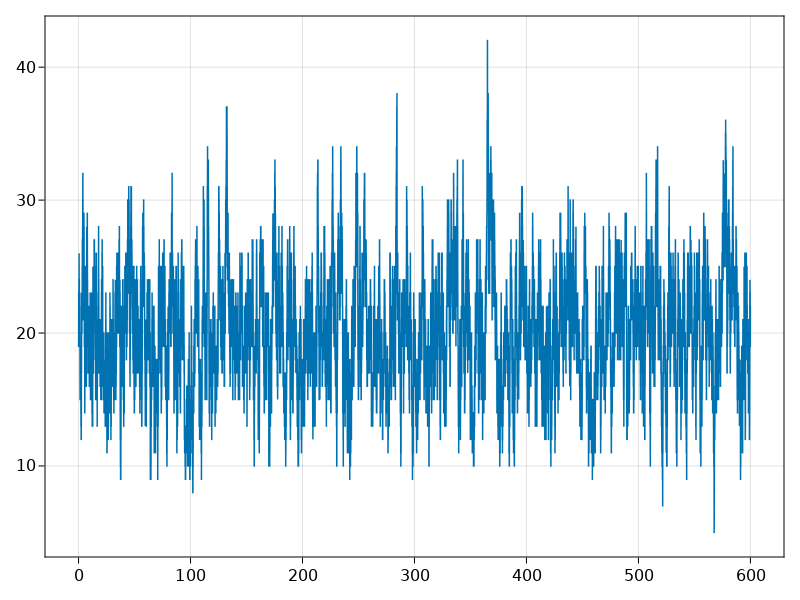

In [390]:
dprob = DiscreteProblem(system.sn, [20], (0.0, 600.0), [20.0, 1.0])
jprob = JumpProblem(system.sn, dprob, Direct())
fluct_s = PWS.collect_trajectory(PWS.SSAIter(init(jprob, SSAStepper())))
lines(fluct_s)

In [391]:
plot_theme = Theme(
    resolution = (243, 100),
    font = "Noto Sans", 
    fontsize = 8, 
    colgap=8, 
    rowgap=0,
    linewidth=2, 
    markersize=5,
    spinewidth=0.5,
    figure_padding=(2,5,2,5),
    Axis = (
        spinewidth=0.5,
        xgridwidth=0.5,
        ygridwidth=0.5,
        xtickwidth=0.5,
        ytickwidth=0.5,
        xticksize=3, 
        yticksize=3,
        xlabelpadding=0,
        ylabelpadding=0,
        xticklabelpad=0,
        yticklabelpad=3,
        # xlabelfont = "DejaVu Sans Condensed",
        # ylabelfont = "DejaVu Sans Condensed",
    ),
    Legend = (
        framevisible=false,
        framewidth=0.5,
        rowgap=0, 
        titlegap=2,
        titlefontsize=11, 
        groupgap=5,
        patchsize=(12,12),
        padding=(0,0,0,0),
        linewidth=1.5,
    )
)
set_theme!(plot_theme)

In [392]:
set_theme!()

In [429]:
@time sol = solve_system(system, ramp_s);

 16.422875 seconds (154.76 k allocations: 14.927 MiB, 0.69% gc time)


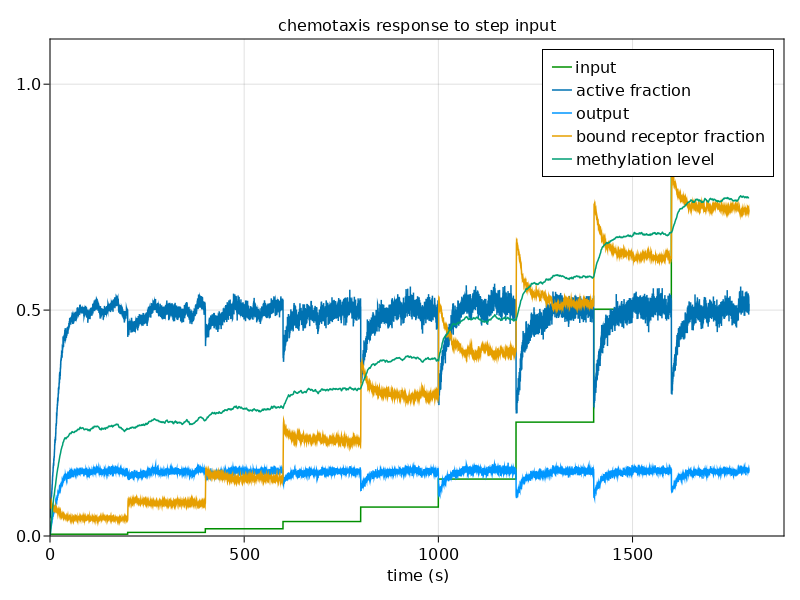

In [430]:
fig = plot_solution(sol, system, active_fraction=true, bound_ligand=true, methylation=true, yp=true)
fig

In [173]:
save("chemotaxis_trajectory.pdf", fig, pt_per_unit = 1)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x00007f8d4758b000, 243.0, 100.0, IOContext(IOStream(<file /Users/mr/Git/PWS/_research/notebooks/chemotaxis_trajectory.pdf>)))


In [344]:
joint = reaction_network(system_no_methylation)
ligand_data = bound_ligands(sol, joint)
methyl_data = bound_methyl(sol, joint)
ligand_data, methyl_data

([6, 13, 12, 8, 10, 17, 12, 10, 14, 9  …  2147, 2136, 2178, 2183, 2125, 2132, 2140, 2167, 2178, 2182], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
using StatsBase

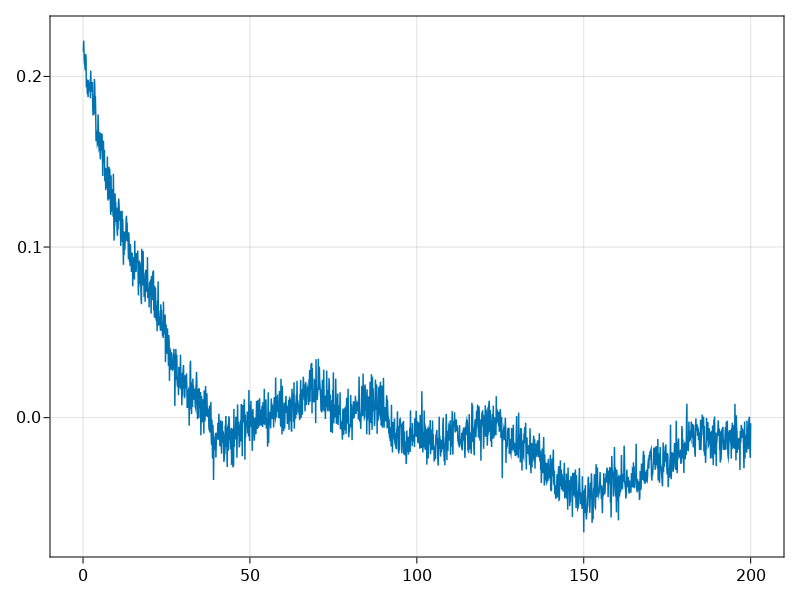

In [228]:
lines(range(0.1, step=0.1, length=2000), autocor(ligand_data, collect(1:2000), demean=true), label="ligand autocorrelation")

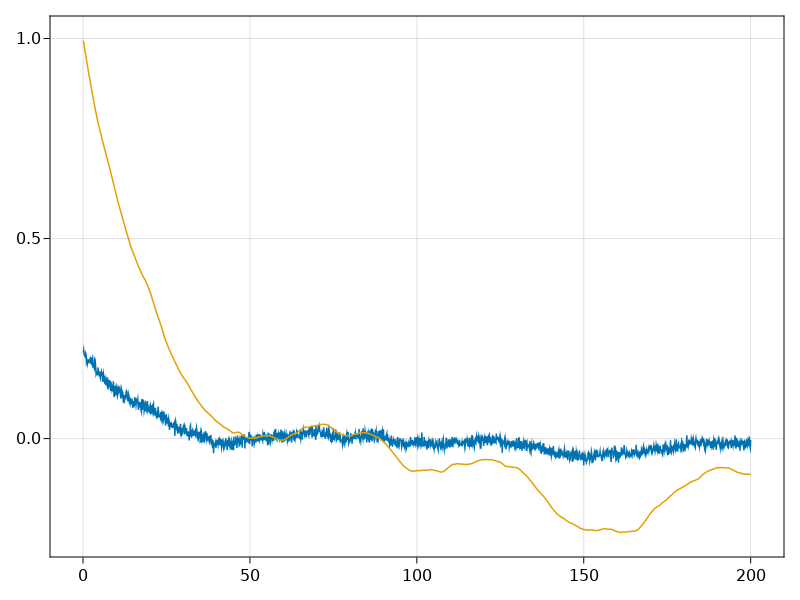

In [229]:
lines(range(0.1, step=0.1, length=2000), autocor(ligand_data, collect(1:2000), demean=true), label="ligand autocorrelation")
lines!(range(0.1, step=0.1, length=2000), autocor(methyl_data, collect(1:2000), demean=true), label="methyl autocorrelation")
current_figure()

# Deactivate Methylation

In [457]:
E0 = -2.0
params_no_methylation = (;
    E₀ = -2.0, # we assume every receptor has a given methylation level
    lmax = lmax,
    mmax = mmax,
    Kₐ = 500, # unit: μM (from MeASP data)
    Kᵢ = 25, # unit: μM
    δf = -1.5,
    k_B = 0.0, # demethylation of active receptor
    k_R = 0.0, # methylation of inactive receptor
    n_clusters = n_clusters,
    k⁺ =  0.2, # ligand binding rate to active or inactive receptor
    n_chey = 10_000,
    mean_l = 50.0,
    tau_l = 1.0,
    phosphorylate = 0.25e-3,
    dephosphorylate = 0.2
)
system_no_methylation = cooperative_chemotaxis_system(; dtimes=0.0:1.0:100.0, params_no_methylation...);

In [458]:
mwc_pa(l) = exp(-E0) * (1 + l/Kₐ)^lmax / ( (1 + l/Kᵢ)^lmax + exp(-E0) * (1 + l/Kₐ)^lmax )

mwc_pa (generic function with 1 method)

  0.056554 seconds (137.70 k allocations: 7.398 MiB)


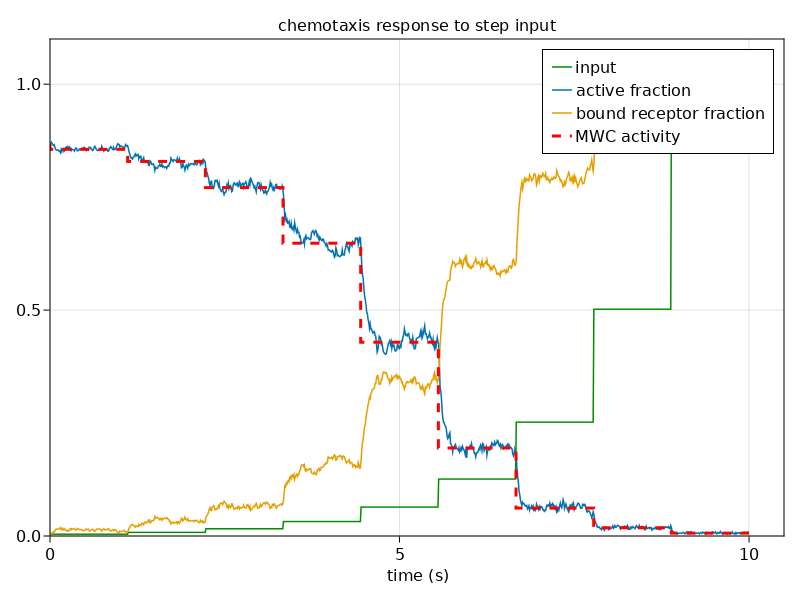

In [459]:
@time sol = solve_system(system_no_methylation, ramp_s, saveat=0.01)
plot_solution(sol, system_no_methylation, yp=false, ligand_concentration=true, methylation=false, bound_ligand=true)
stairs!(ramp_s.t, mwc_pa.(getindex.(ramp_s.u, 1)), linestyle=:dash, linewidth=3, label="MWC activity", color=:red)
axislegend()
current_figure()

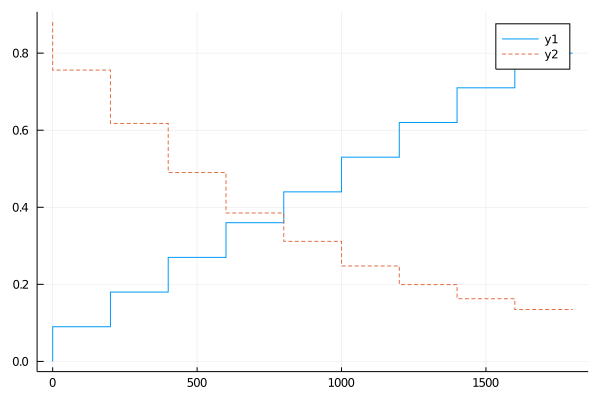

In [41]:
p = plot(ramp_s.t, getindex.(ramp_s.u, 1) ./ 100, seriestype=:steppre)
plot!(p, ramp_s.t, mwc_pa.(getindex.(ramp_s.u, 1)), seriestype=:steppre, linestyle=:dash)

In [50]:
using Printf

println("R_l_k: Receptor with l bound ligands and k-times methylated")
for r in Catalyst.reactions(system.rn)
    f = ModelingToolkit.build_function(r.rate, Catalyst.params(system.rn), expression=Val{false})
    l, m = parse_receptor(r.substrates[1])
    @printf "%s --> %s ; k = %6.3f ; p_active = %.3f\n" getname(r.substrates[1]) getname(r.products[1]) f(params) p_active(l, m)
end

R_l_k: Receptor with l bound ligands and k-times methylated
R_0_1 --> R_0_0 ; k =  0.002 ; p_active = 0.047
R_0_0 --> R_0_1 ; k =  0.049 ; p_active = 0.018
R_0_2 --> R_0_1 ; k =  0.006 ; p_active = 0.119
R_0_1 --> R_0_2 ; k =  0.048 ; p_active = 0.047
R_0_3 --> R_0_2 ; k =  0.013 ; p_active = 0.269
R_0_2 --> R_0_3 ; k =  0.044 ; p_active = 0.119
R_0_4 --> R_0_3 ; k =  0.025 ; p_active = 0.500
R_0_3 --> R_0_4 ; k =  0.037 ; p_active = 0.269
R_0_5 --> R_0_4 ; k =  0.037 ; p_active = 0.731
R_0_4 --> R_0_5 ; k =  0.025 ; p_active = 0.500
R_0_6 --> R_0_5 ; k =  0.044 ; p_active = 0.881
R_0_5 --> R_0_6 ; k =  0.013 ; p_active = 0.731
R_0_7 --> R_0_6 ; k =  0.048 ; p_active = 0.953
R_0_6 --> R_0_7 ; k =  0.006 ; p_active = 0.881
R_0_8 --> R_0_7 ; k =  0.049 ; p_active = 0.982
R_0_7 --> R_0_8 ; k =  0.002 ; p_active = 0.953
R_0_9 --> R_0_8 ; k =  0.050 ; p_active = 0.993
R_0_8 --> R_0_9 ; k =  0.001 ; p_active = 0.982
R_0_0 --> R_1_0 ; k =  0.150 ; p_active = 0.018
R_1_0 --> R_0_0 ; k =  1.272

In [120]:
Catalyst.numreactions(system.rn) + Catalyst.numreactions(system.xn)

173

In [190]:
a_star = 0.33
# g(ℓ, m, ligand) = ligand / (p_active(ℓ+1,m) * (Kₐ-Kᵢ) + Kᵢ + ligand)
g(ligand) = ligand / (a_star * (Kₐ-Kᵢ) + Kᵢ + ligand)

g (generic function with 2 methods)

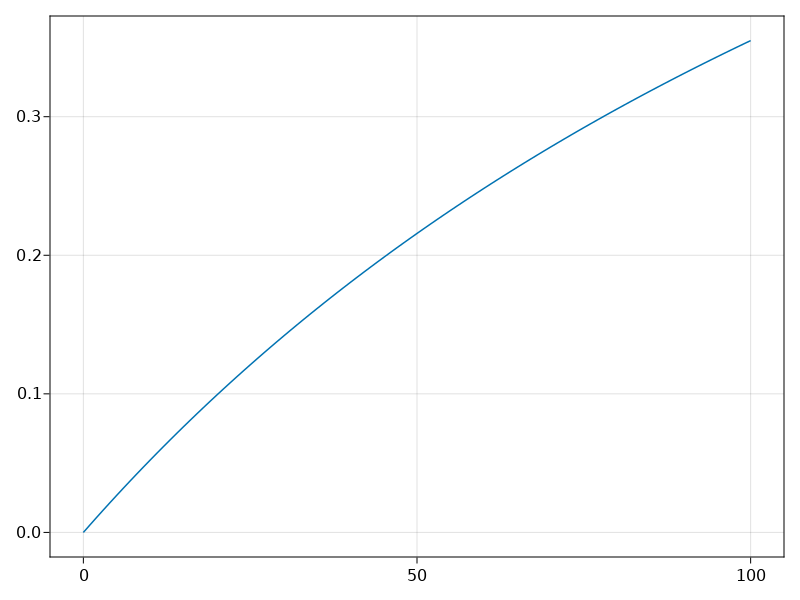

In [191]:
ligand_c = 0:1:100
lines(ligand_c, g.(ligand_c))